In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ''
# os.environ['HF_HOME'] = ''

import json
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from datetime import datetime
import numpy as np
import sys
sys.path.append('fkd_diffusers')

import torch
from diffusers import DDIMScheduler

from launch_eval_runs import do_eval

/home/revant/Documents/Fk-Diffusion-Steering/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/revant/Documents/Fk-Diffusion-Steering/venv/lib/python3.12/site-packages/diffusers/schedulers/scheduling_dpmsolver_multistep.py:30: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  import scipy.stats


In [2]:
# Set args
"""
model_choices:

stable-diffusion-xl
stable-diffusion-v1-5
stable-diffusion-v1-4
stable-diffusion-2-1
"""

args = dict(
    seed=0,
    output_dir="output", 
    eta=1.0,
    metrics_to_compute="MixPoseValidityAndHumanPreference", 
    prompt_path='./prompt_files/image_rewards_benchmark.json', 
    model_name="stable-diffusion-v1-5", 
  )

fkd_args = dict(
    lmbda=2.0,
    num_particles=4,
    adaptive_resampling=True,
    resample_frequency=20,
    time_steps=100,
    potential_type='max',
    resampling_t_start=20,
    resampling_t_end=50,
    guidance_reward_fn='MixPoseValidityAndHumanPreference',
    use_smc=True,
   )

args = argparse.Namespace(**args, **fkd_args)
args

Namespace(seed=0, output_dir='output', eta=1.0, metrics_to_compute='MixPoseValidityAndHumanPreference', prompt_path='./prompt_files/image_rewards_benchmark.json', model_name='stable-diffusion-v1-5', lmbda=2.0, num_particles=4, adaptive_resampling=True, resample_frequency=20, time_steps=100, potential_type='max', resampling_t_start=20, resampling_t_end=50, guidance_reward_fn='MixPoseValidityAndHumanPreference', use_smc=True)

In [3]:
args.num_inference_steps = fkd_args["time_steps"]
fkd_args

{'lmbda': 2.0,
 'num_particles': 4,
 'adaptive_resampling': True,
 'resample_frequency': 20,
 'time_steps': 100,
 'potential_type': 'max',
 'resampling_t_start': 20,
 'resampling_t_end': 50,
 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference',
 'use_smc': True}

In [4]:
# seed everything
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [5]:
# set output directory
cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = os.path.join(args.output_dir, cur_time)
os.makedirs(output_dir, exist_ok=False)
arg_path = os.path.join(output_dir, "args.json")
with open(arg_path, "w") as f:
    json.dump(vars(args), f, indent=4)

score_path = os.path.join(output_dir, "scores.jsonl")
images_path = os.path.join(output_dir, "images")
os.makedirs(images_path, exist_ok=False)

metrics_to_compute = args.metrics_to_compute.split("#")


# cache metric fns
do_eval(
    prompt=["test"],
    images=[Image.new("RGB", (224, 224))],
    metrics_to_compute=metrics_to_compute,
    )


INFO:root:Loaded ViT-H-14 model config.


Hello eval time


INFO:root:Loading pretrained ViT-H-14 weights (laion2B-s32B-b79K).


Human preference scores: [0.173583984375]
Loading ViTPose...
ViTPose loaded
Loading VAE model from /home/revant/Documents/Fk-Diffusion-Steering/swimming_pose_reward/pose_vae_side_swimming.pt...
Standardization parameters loaded from model file
VAE model loaded and ready
Pose validity scores: [-1.256468126501861e+21]
Normalized human preference scores: [0.0]
Normalized pose validity scores: [0.0]


{'MixPoseValidityAndHumanPreference': {'result': [0.0],
  'mean': 0.0,
  'std': nan,
  'max': 0.0,
  'min': 0.0}}

In [6]:
from fks_utils import get_model

pipeline = get_model(args.model_name)
print("Using model:", args.model_name)
pipeline = pipeline.to("cuda")


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


Using model: stable-diffusion-v1-5


In [7]:
# add prompts for generation
prompt_data = [
    {"prompt": "A swimmer performing the backstroke in a swimming pool, side view, realistic lighting and water reflections."},
    {"prompt": "A swimmer doing the breaststroke, viewed from a slightly elevated diagonal angle showing the side of the body, realistic lighting and water reflections."},
    {"prompt": "A swimmer performing the butterfly stroke, top-down view, realistic lighting and water reflections."},
    {"prompt": "A swimmer doing freestyle, side view from underwater, realistic lighting"},
    {"prompt": "Side view of a swimmer, freestyle stroke."},
    {"prompt": "A swimmer doing the freestyle, side view, splashing water."},
    {"prompt": "Side view, swimmer, freestyle, breathing."},
    {"prompt": "Underwater side view, full body, swimmer, freestyle kick."},
]

len(prompt_data)

8

In [8]:
show_best_particle = True

A swimmer performing the backstroke in a swimming pool, side view, realistic lighting and water reflections.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.37it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.62it/s]

Human preference scores: [0.1151123046875, 0.186279296875, 0.1396484375, 0.13232421875]
Pose validity scores: [-2.9552226066589355, -0.7757527828216553, -2.4354379177093506, -0.34689807891845703]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.7044777393341064, 0.9224247217178345, 0.7564562082290649, 0.9653101921081543]


 40%|████      | 40/100 [00:04<00:04, 13.54it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:22,  2.59it/s]

Human preference scores: [0.18212890625, 0.2255859375, 0.189208984375, 0.13818359375]
Pose validity scores: [-0.24464869499206543, -1.475665807723999, -0.4286596179008484, -0.5058926343917847]
Normalized human preference scores: [0.0, 0.17057291666666663, 0.0, 0.0]
Normalized pose validity scores: [0.9755351305007934, 0.8524334192276001, 0.9571340382099152, 0.9494107365608215]


 98%|█████████▊| 98/100 [00:10<00:00, 16.19it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]

Human preference scores: [0.259521484375, 0.265869140625, 0.247802734375, 0.25244140625]
Pose validity scores: [-0.712299108505249, -3.0005910396575928, -0.3459710478782654, -0.5691998600959778]
Normalized human preference scores: [0.39680989583333337, 0.4391276041666667, 0.3186848958333333, 0.349609375]
Normalized pose validity scores: [0.9287700891494751, 0.6999408960342407, 0.9654028952121735, 0.9430800139904022]
Hello eval time


Human preference scores: [0.26171875, 0.2666015625, 0.2498779296875, 0.253173828125]
Pose validity scores: [-1.091942548751831, -1.9905961751937866, -0.3744391202926636, -0.5635451078414917]
Normalized human preference scores: [0.41145833333333337, 0.4440104166666667, 0.33251953125, 0.3544921875]
Normalized pose validity scores: [0.8908057451248169, 0.8009403824806214, 0.9625560879707337, 0.9436454892158508]


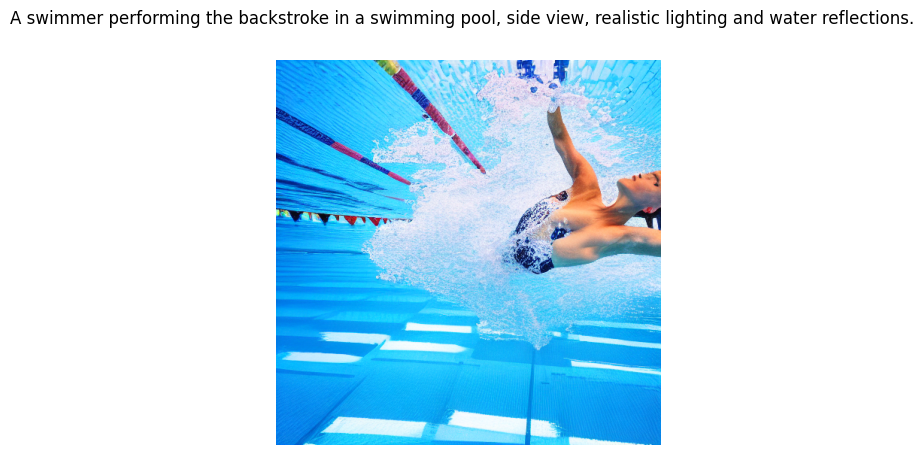

A swimmer doing the breaststroke, viewed from a slightly elevated diagonal angle showing the side of the body, realistic lighting and water reflections.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.26it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.61it/s]

Human preference scores: [0.1256103515625, 0.1646728515625, 0.1580810546875, 0.153076171875]
Pose validity scores: [-0.19184136390686035, -0.7295638918876648, -0.4092327356338501, -0.4768775403499603]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.9808158636093139, 0.9270436108112335, 0.959076726436615, 0.952312245965004]


 40%|████      | 40/100 [00:04<00:04, 13.48it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:22,  2.63it/s]

Human preference scores: [0.17138671875, 0.18408203125, 0.187744140625, 0.225341796875]
Pose validity scores: [-2.531264305114746, -4.282723903656006, -0.43125981092453003, -0.38040876388549805]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.16894531249999997]
Normalized pose validity scores: [0.7468735694885253, 0.5717276096343994, 0.956874018907547, 0.9619591236114502]


 98%|█████████▊| 98/100 [00:10<00:00, 16.16it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]

Human preference scores: [0.2388916015625, 0.26904296875, 0.25439453125, 0.292724609375]
Pose validity scores: [-2.4643049240112305, -3.3933258056640625, -0.8640836477279663, -0.6615573167800903]
Normalized human preference scores: [0.25927734375, 0.46028645833333337, 0.3626302083333333, 0.6181640625000001]
Normalized pose validity scores: [0.753569507598877, 0.6606674194335938, 0.9135916352272033, 0.933844268321991]
Hello eval time


Human preference scores: [0.2396240234375, 0.270263671875, 0.25537109375, 0.29296875]
Pose validity scores: [-2.1144165992736816, -3.319782257080078, -0.7206546664237976, -1.015516996383667]
Normalized human preference scores: [0.26416015625, 0.4684244791666667, 0.369140625, 0.6197916666666667]
Normalized pose validity scores: [0.7885583400726318, 0.6680217742919922, 0.9279345333576202, 0.8984483003616333]


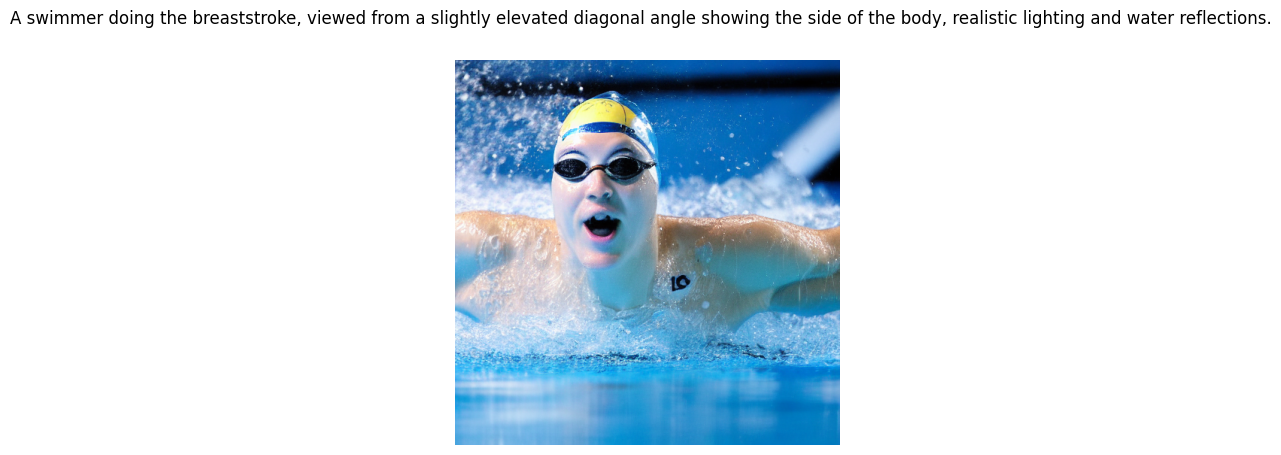

A swimmer performing the butterfly stroke, top-down view, realistic lighting and water reflections.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.35it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.68it/s]

Human preference scores: [0.091552734375, 0.1380615234375, 0.134521484375, 0.1253662109375]
Pose validity scores: [-3.8685994148254395, -0.32798564434051514, -0.653797447681427, -0.6106078624725342]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.613140058517456, 0.9672014355659485, 0.9346202552318573, 0.9389392137527466]


 40%|████      | 40/100 [00:04<00:04, 13.57it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:21,  2.68it/s]

Human preference scores: [0.1324462890625, 0.197265625, 0.17919921875, 0.198486328125]
Pose validity scores: [-0.5020032525062561, -0.7400459051132202, -0.4059942662715912, -0.20018893480300903]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.9497996747493744, 0.925995409488678, 0.9594005733728409, 0.979981106519699]


 98%|█████████▊| 98/100 [00:10<00:00, 16.24it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]

Human preference scores: [0.2120361328125, 0.2491455078125, 0.20751953125, 0.2353515625]
Pose validity scores: [-0.5759620070457458, -0.9245495200157166, -0.41752147674560547, -0.447303831577301]
Normalized human preference scores: [0.08024088541666662, 0.32763671875, 0.05013020833333327, 0.23567708333333331]
Normalized pose validity scores: [0.9424037992954254, 0.9075450479984284, 0.9582478523254394, 0.9552696168422699]
Hello eval time


Human preference scores: [0.211669921875, 0.248779296875, 0.207763671875, 0.2349853515625]
Pose validity scores: [-0.6291007995605469, -0.7648298740386963, -0.4063563942909241, -0.2359316349029541]
Normalized human preference scores: [0.07779947916666662, 0.3251953125, 0.05175781249999994, 0.23323567708333331]
Normalized pose validity scores: [0.9370899200439453, 0.9235170125961304, 0.9593643605709076, 0.9764068365097046]


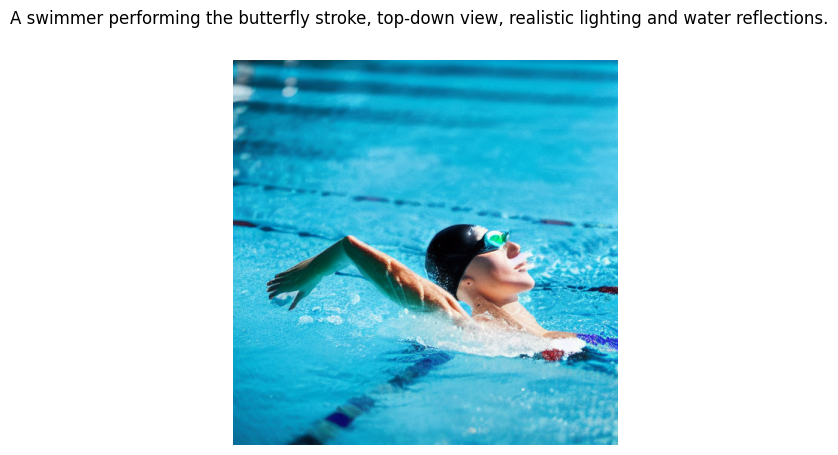

A swimmer doing freestyle, side view from underwater, realistic lighting
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.37it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.63it/s]

Human preference scores: [0.148193359375, 0.1597900390625, 0.1422119140625, 0.1807861328125]
Pose validity scores: [-0.7850160002708435, -0.9412980079650879, -0.16663286089897156, -0.31807851791381836]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.9214983999729156, 0.9058701992034912, 0.9833367139101028, 0.9681921482086182]


 40%|████      | 40/100 [00:04<00:04, 13.55it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:21,  2.66it/s]

Human preference scores: [0.180908203125, 0.21728515625, 0.2060546875, 0.1961669921875]
Pose validity scores: [-0.7845954298973083, -0.7315914034843445, -0.3931938111782074, -0.4744597375392914]
Normalized human preference scores: [0.0, 0.11523437499999996, 0.040364583333333266, 0.0]
Normalized pose validity scores: [0.9215404570102692, 0.9268408596515656, 0.9606806188821793, 0.9525540262460709]


 98%|█████████▊| 98/100 [00:10<00:00, 16.25it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]

Human preference scores: [0.24755859375, 0.253173828125, 0.2452392578125, 0.27197265625]
Pose validity scores: [-0.859358012676239, -18.077138900756836, -0.4610369801521301, -0.5273215174674988]
Normalized human preference scores: [0.3170572916666667, 0.3544921875, 0.3015950520833333, 0.47981770833333337]
Normalized pose validity scores: [0.9140641987323761, 0.0, 0.953896301984787, 0.9472678482532502]
Hello eval time


Human preference scores: [0.246337890625, 0.25732421875, 0.2452392578125, 0.273193359375]
Pose validity scores: [-0.23115240037441254, -179.85198974609375, -0.4670660197734833, -0.5408281683921814]
Normalized human preference scores: [0.3089192708333333, 0.38216145833333337, 0.3015950520833333, 0.4879557291666667]
Normalized pose validity scores: [0.9768847599625587, 0.0, 0.9532933980226517, 0.9459171831607819]


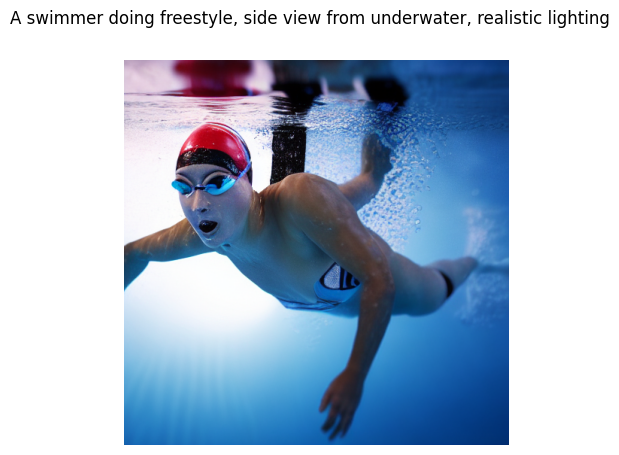

Side view of a swimmer, freestyle stroke.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.40it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.67it/s]

Human preference scores: [0.1328125, 0.1470947265625, 0.1729736328125, 0.18017578125]
Pose validity scores: [-2.3358516693115234, -0.6146750450134277, -0.8281166553497314, -0.7952541708946228]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.7664148330688476, 0.9385324954986572, 0.9171883344650269, 0.9204745829105377]


 40%|████      | 40/100 [00:04<00:04, 13.59it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:22,  2.62it/s]

Human preference scores: [0.16455078125, 0.2154541015625, 0.193115234375, 0.2159423828125]
Pose validity scores: [-0.6960266828536987, -2.215003490447998, -0.748558521270752, -0.9117066264152527]
Normalized human preference scores: [0.0, 0.10302734374999994, 0.0, 0.10628255208333329]
Normalized pose validity scores: [0.9303973317146301, 0.7784996509552002, 0.9251441478729248, 0.9088293373584747]


 98%|█████████▊| 98/100 [00:10<00:00, 16.25it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]

Human preference scores: [0.254150390625, 0.267578125, 0.275146484375, 0.2744140625]
Pose validity scores: [-8.816178321838379, -1.4078357219696045, -0.8732978105545044, -1.1409982442855835]
Normalized human preference scores: [0.3610026041666667, 0.45052083333333337, 0.5009765625, 0.49609375000000006]
Normalized pose validity scores: [0.1183821678161621, 0.8592164278030395, 0.9126702189445496, 0.8859001755714416]
Hello eval time


Human preference scores: [0.256103515625, 0.266845703125, 0.27783203125, 0.275634765625]
Pose validity scores: [-5.395373344421387, -1.4297469854354858, -0.8704453706741333, -1.3908054828643799]
Normalized human preference scores: [0.3740234375, 0.44563802083333337, 0.5188802083333334, 0.5042317708333334]
Normalized pose validity scores: [0.4604626655578613, 0.8570253014564514, 0.9129554629325867, 0.860919451713562]


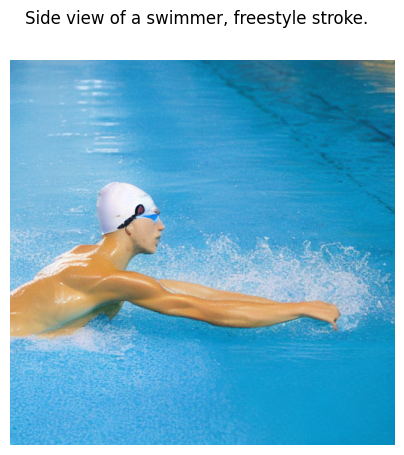

A swimmer doing the freestyle, side view, splashing water.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.33it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:30,  2.53it/s]

Human preference scores: [0.1322021484375, 0.1683349609375, 0.155517578125, 0.1307373046875]
Pose validity scores: [-5.876460075378418, -0.7018710374832153, -0.89129638671875, -13.473190307617188]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.4123539924621582, 0.9298128962516785, 0.910870361328125, 0.0]


 40%|████      | 40/100 [00:04<00:04, 13.44it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:21,  2.64it/s]

Human preference scores: [0.2027587890625, 0.1995849609375, 0.212158203125, 0.2108154296875]
Pose validity scores: [-0.4460465908050537, -9.708236694335938, -0.4891190528869629, -0.8508210182189941]
Normalized human preference scores: [0.018391927083333263, 0.0, 0.08105468749999994, 0.07210286458333327]
Normalized pose validity scores: [0.9553953409194946, 0.02917633056640625, 0.9510880947113037, 0.9149178981781005]


 98%|█████████▊| 98/100 [00:10<00:00, 16.26it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]

Human preference scores: [0.300048828125, 0.268310546875, 0.270263671875, 0.279541015625]
Pose validity scores: [-3.0697240829467773, -1.5797173976898193, -0.5244174003601074, -0.9401718974113464]
Normalized human preference scores: [0.6669921875000001, 0.45540364583333337, 0.4684244791666667, 0.5302734375]
Normalized pose validity scores: [0.6930275917053222, 0.8420282602310181, 0.9475582599639892, 0.9059828102588654]
Hello eval time


Human preference scores: [0.300537109375, 0.267578125, 0.27099609375, 0.27978515625]
Pose validity scores: [-3.0259358882904053, -2.136625289916992, -0.49879106879234314, -1.1426889896392822]
Normalized human preference scores: [0.6702473958333334, 0.45052083333333337, 0.4733072916666667, 0.5319010416666667]
Normalized pose validity scores: [0.6974064111709595, 0.7863374710083008, 0.9501208931207656, 0.8857311010360718]


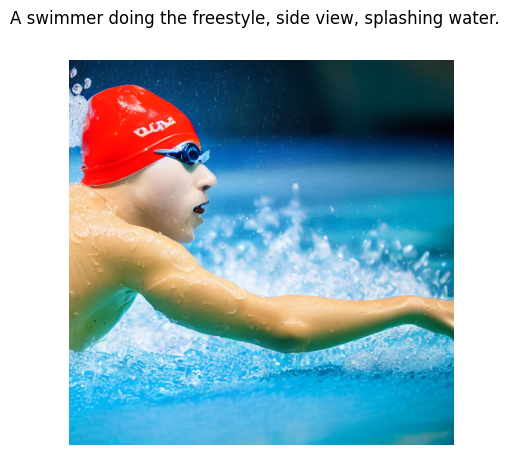

Side view, swimmer, freestyle, breathing.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.45it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:30,  2.52it/s]

Human preference scores: [0.129150390625, 0.1904296875, 0.150634765625, 0.1666259765625]
Pose validity scores: [-0.26808807253837585, -7.537008285522461, -2.159672260284424, -0.6904711127281189]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.9731911927461624, 0.2462991714477539, 0.7840327739715576, 0.9309528887271881]


 40%|████      | 40/100 [00:04<00:04, 13.42it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:21,  2.66it/s]

Human preference scores: [0.153564453125, 0.225830078125, 0.1689453125, 0.183349609375]
Pose validity scores: [-1.2609989643096924, -0.563126802444458, -0.5077129602432251, -0.5092085003852844]
Normalized human preference scores: [0.0, 0.1722005208333333, 0.0, 0.0]
Normalized pose validity scores: [0.8739001035690308, 0.9436873197555542, 0.9492287039756775, 0.9490791499614716]


 98%|█████████▊| 98/100 [00:10<00:00, 16.26it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]

Human preference scores: [0.22119140625, 0.26220703125, 0.2342529296875, 0.2249755859375]
Pose validity scores: [-0.7857241630554199, -0.9167357683181763, -0.46657344698905945, -0.5313372611999512]
Normalized human preference scores: [0.14127604166666663, 0.4147135416666667, 0.22835286458333331, 0.16650390624999997]
Normalized pose validity scores: [0.921427583694458, 0.9083264231681824, 0.9533426553010941, 0.9468662738800049]
Hello eval time


Human preference scores: [0.220703125, 0.260009765625, 0.23388671875, 0.2244873046875]
Pose validity scores: [-0.8206314444541931, -1.0857269763946533, -0.46567603945732117, -0.7994458675384521]
Normalized human preference scores: [0.1380208333333333, 0.4000651041666667, 0.22591145833333331, 0.16324869791666663]
Normalized pose validity scores: [0.9179368555545807, 0.8914273023605347, 0.9534323960542679, 0.9200554132461548]


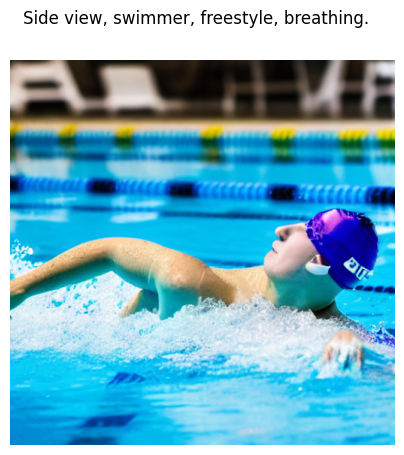

Underwater side view, full body, swimmer, freestyle kick.
Args: {'lmbda': 2.0, 'num_particles': 4, 'adaptive_resampling': True, 'resample_frequency': 20, 'time_steps': 100, 'potential_type': 'max', 'resampling_t_start': 20, 'resampling_t_end': 50, 'guidance_reward_fn': 'MixPoseValidityAndHumanPreference', 'use_smc': True}


 20%|██        | 20/100 [00:01<00:04, 16.34it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 22%|██▏       | 22/100 [00:03<00:29,  2.67it/s]

Human preference scores: [0.1513671875, 0.126220703125, 0.14892578125, 0.1304931640625]
Pose validity scores: [-97.25244140625, -0.6328845620155334, -0.5574266314506531, -0.3388218283653259]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.0, 0.9367115437984467, 0.9442573368549347, 0.9661178171634675]


 40%|████      | 40/100 [00:04<00:04, 13.86it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


 42%|████▏     | 42/100 [00:06<00:22,  2.53it/s]

Human preference scores: [0.193115234375, 0.1788330078125, 0.1878662109375, 0.184326171875]
Pose validity scores: [-0.5153965950012207, -0.6319364309310913, -0.4638217091560364, -0.48677679896354675]
Normalized human preference scores: [0.0, 0.0, 0.0, 0.0]
Normalized pose validity scores: [0.9484603404998779, 0.9368063569068908, 0.9536178290843964, 0.9513223201036454]


 98%|█████████▊| 98/100 [00:10<00:00, 16.33it/s]

`metric_to_chase` will be ignored as it only applies to 'LLMGrader' as the `reward_name`


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]

Human preference scores: [0.2491455078125, 0.21875, 0.231689453125, 0.25830078125]
Pose validity scores: [-0.5154876708984375, -1.679049015045166, -0.3980579376220703, -0.30065107345581055]
Normalized human preference scores: [0.32763671875, 0.12499999999999996, 0.21126302083333331, 0.388671875]
Normalized pose validity scores: [0.9484512329101562, 0.8320950984954834, 0.960194206237793, 0.9699348926544189]
Hello eval time


Human preference scores: [0.251220703125, 0.22021484375, 0.232666015625, 0.259521484375]
Pose validity scores: [-0.5573832392692566, -1.8040428161621094, -0.42243191599845886, -0.3631915748119354]
Normalized human preference scores: [0.3414713541666667, 0.13476562499999994, 0.21777343749999997, 0.39680989583333337]
Normalized pose validity scores: [0.9442616760730743, 0.8195957183837891, 0.9577568084001541, 0.9636808425188065]


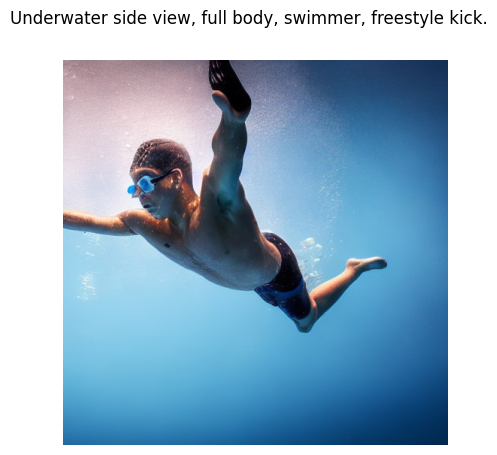

In [9]:
with open(score_path, "w") as score_f:
    for prompt_idx, item in enumerate(prompt_data):
        print(item['prompt'])
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
        
        
        prompt = [item['prompt']]*fkd_args['num_particles']
        start_time = datetime.now()
        
        images = pipeline(prompt, 
                          num_inference_steps=fkd_args["time_steps"], 
                          eta=args.eta,
                          fkd_args=fkd_args)
        end_time = datetime.now()        
        images = images[0]

        time_taken = end_time - start_time
        
        results = do_eval(prompt=prompt, images=images, metrics_to_compute=metrics_to_compute)
        guidance_reward = np.array(results["MixPoseValidityAndHumanPreference"]["result"])
        sorted_idx = np.argsort(guidance_reward)[::-1]
        images = [images[i] for i in sorted_idx]
        
        results['time_taken'] = time_taken.total_seconds()
        results['prompt'] = prompt
        results['prompt_index'] = prompt_idx

        image_fpath = os.path.join(images_path, f"{prompt_idx}.png")
        results['image_path'] = image_fpath

        score_f.write(json.dumps(results) + "\n")
        
        if show_best_particle:
            _, ax = plt.subplots(1, 1, figsize=(5, 5))            
            ax.imshow(images[0])
            ax.axis("off")
        else:
            _, ax = plt.subplots(1, args.num_particles, figsize=(args.num_particles*5, 5))
            for i, image in enumerate(images):
                ax[i].imshow(image)
                ax[i].axis("off")
                
        plt.suptitle(prompt[0])
        plt.savefig(image_fpath)
        plt.show()
        plt.close()


In [ ]:
from diffusers import StableDiffusionPipeline

pipe_sd = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
pipe_sd = pipe_sd.to("cuda")
print("Loaded vanilla Stable Diffusion v1-5 (no FK Steering)")

In [ ]:
with open(score_path, "w") as score_f:
    for prompt_idx, item in enumerate(prompt_data):
        prompt_text = item["prompt"]
        print(prompt_text)
        torch.manual_seed(0)
        start_time = datetime.now()

        out = pipe_sd(
            prompt=prompt_text,
            num_inference_steps=50, 
            guidance_scale=7.5 
        )
        image = out.images[0]

        end_time = datetime.now()
        time_taken = (end_time - start_time).total_seconds()

        image_fpath = os.path.join(images_path, f"{prompt_idx}.png")
        image.save(image_fpath)

        result_record = {
            "prompt": prompt_text,
            "prompt_index": prompt_idx,
            "time_taken": time_taken,
            "image_path": image_fpath
        }
        score_f.write(json.dumps(result_record) + "\n")

        plt.figure(figsize=(5,5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(prompt_text)
        plt.savefig(image_fpath)
        plt.show()
        plt.close()

In [11]:
experiment_output_ids = {
    "20251121-181917": "Vanilla SD v1.5",
    "20251121-180043": "FK Steering with Human Preference Reward",
    "20251121-190817": "FK Steering with Pose Reward",
    "20251121-203542": "FK Steering with Mixed Pose and Human Preference Reward"
}

Found indices: [0, 1, 2, 3, 4, 5, 6, 7]


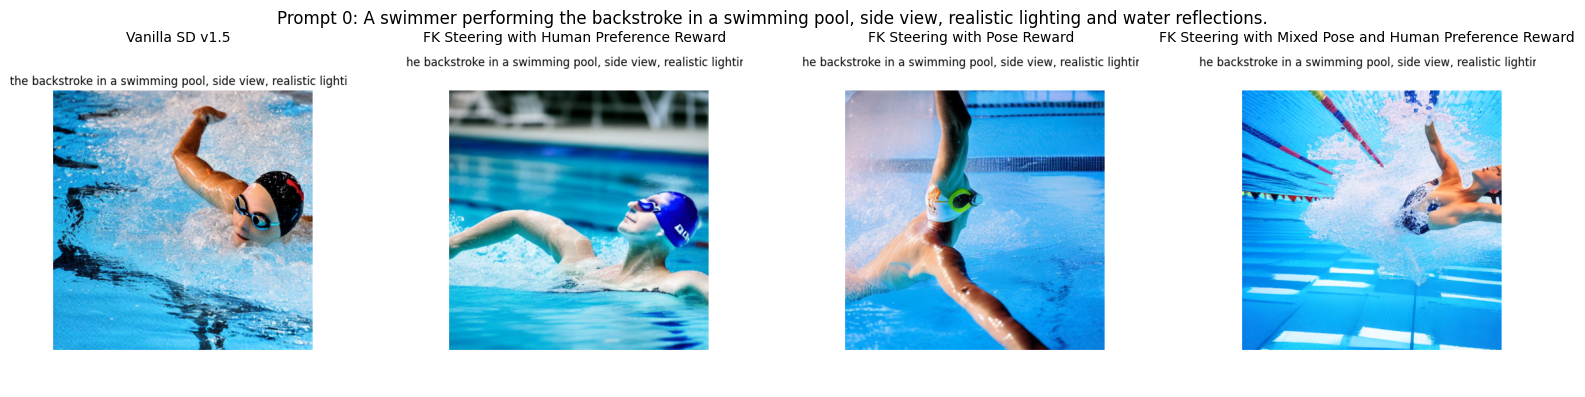

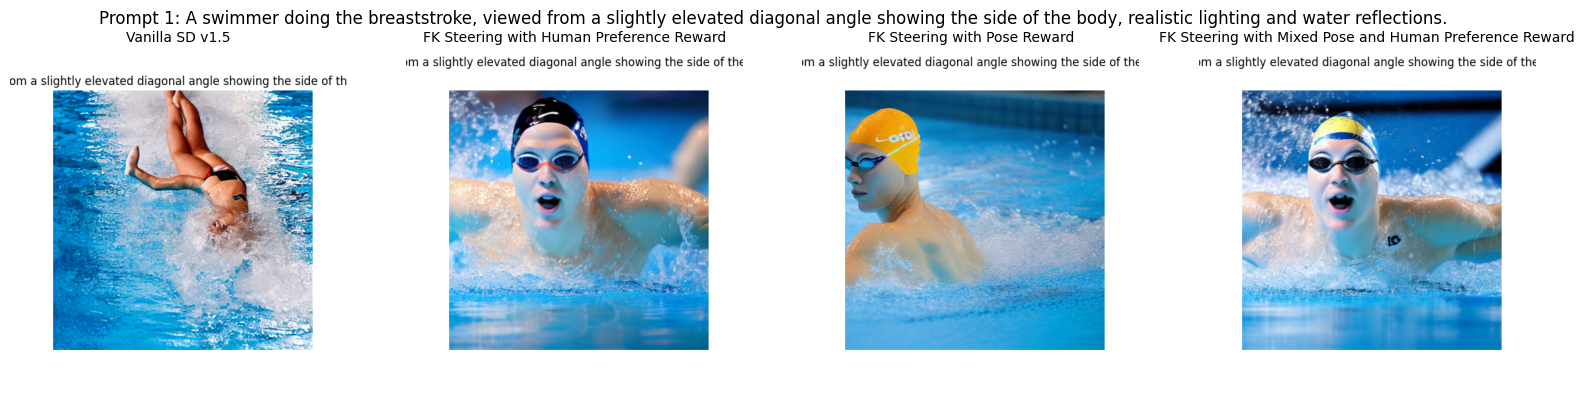

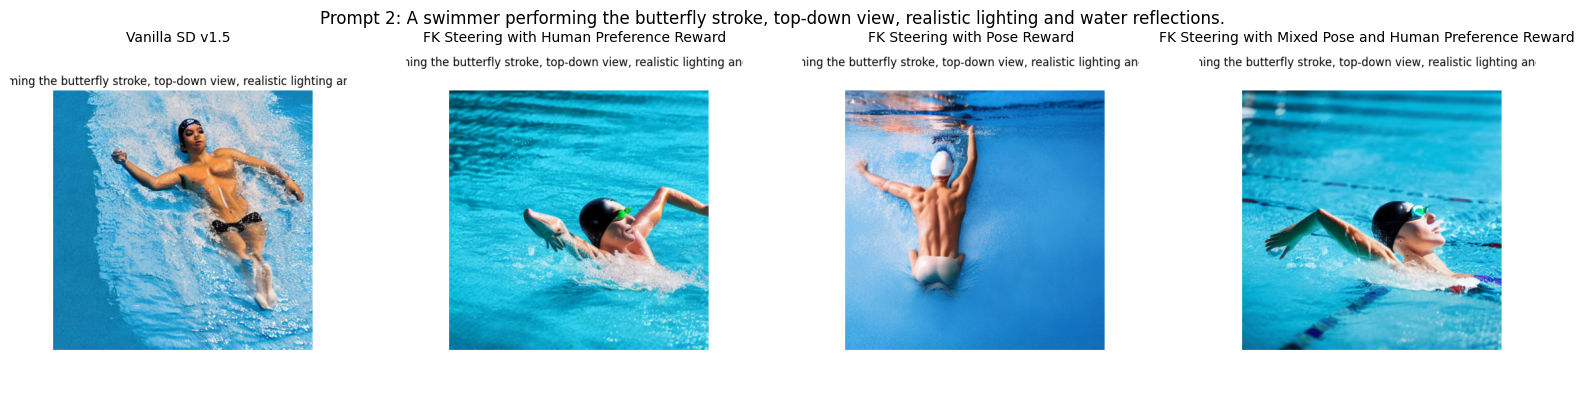

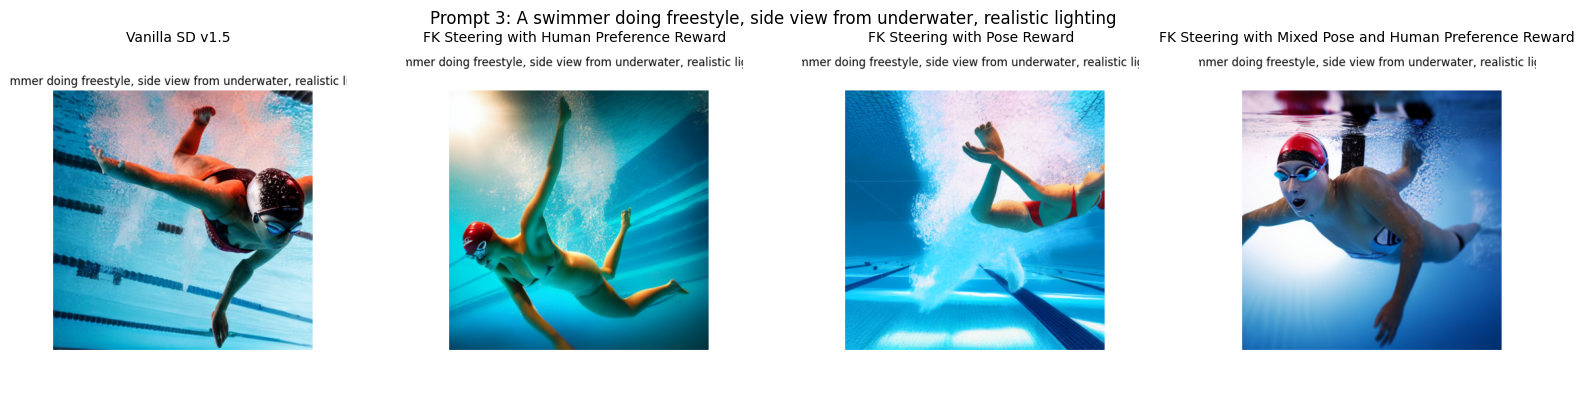

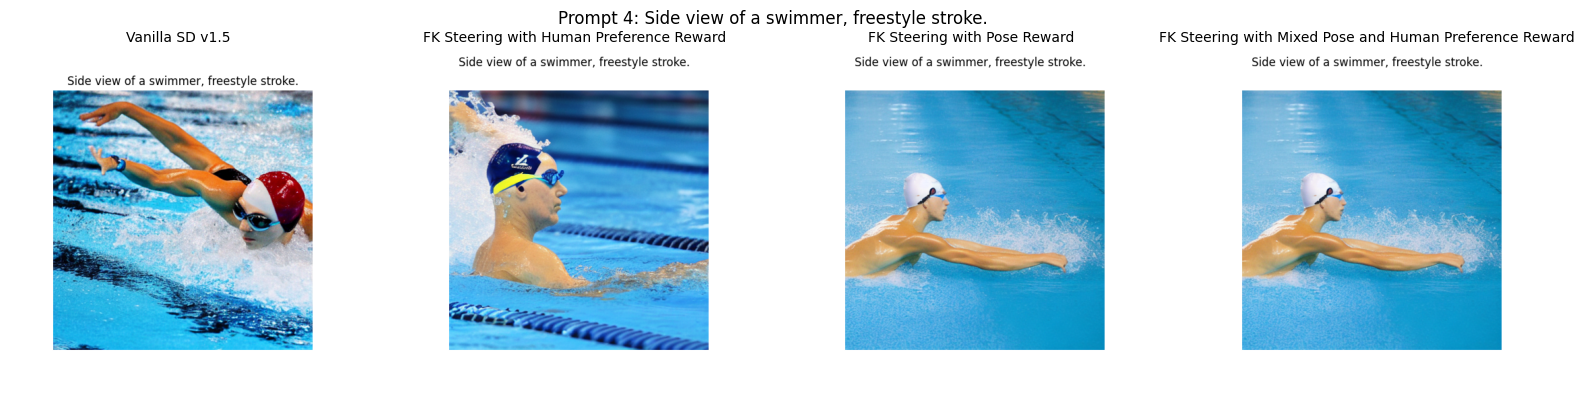

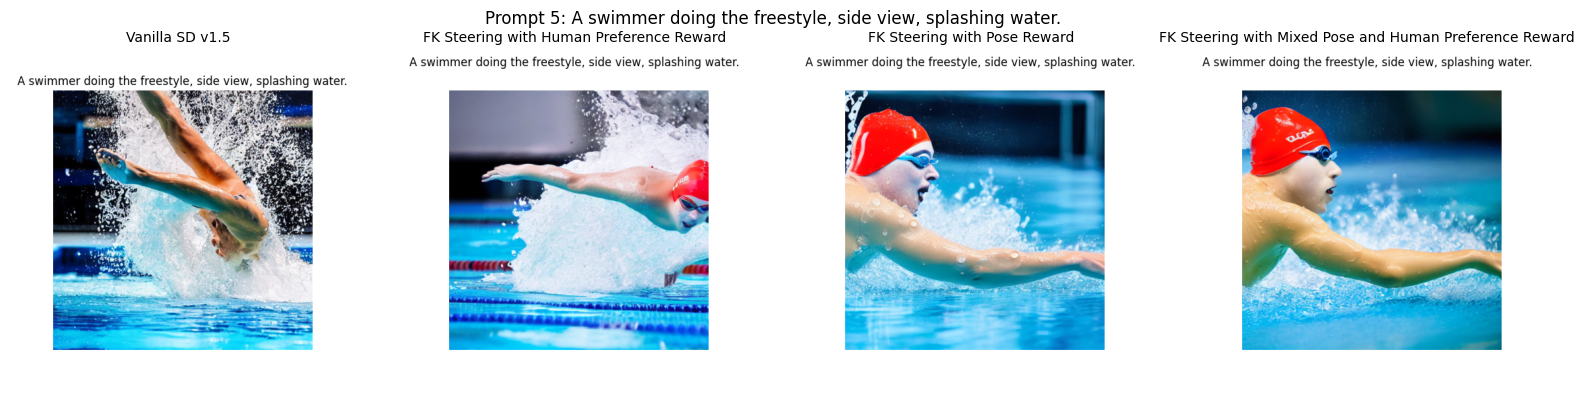

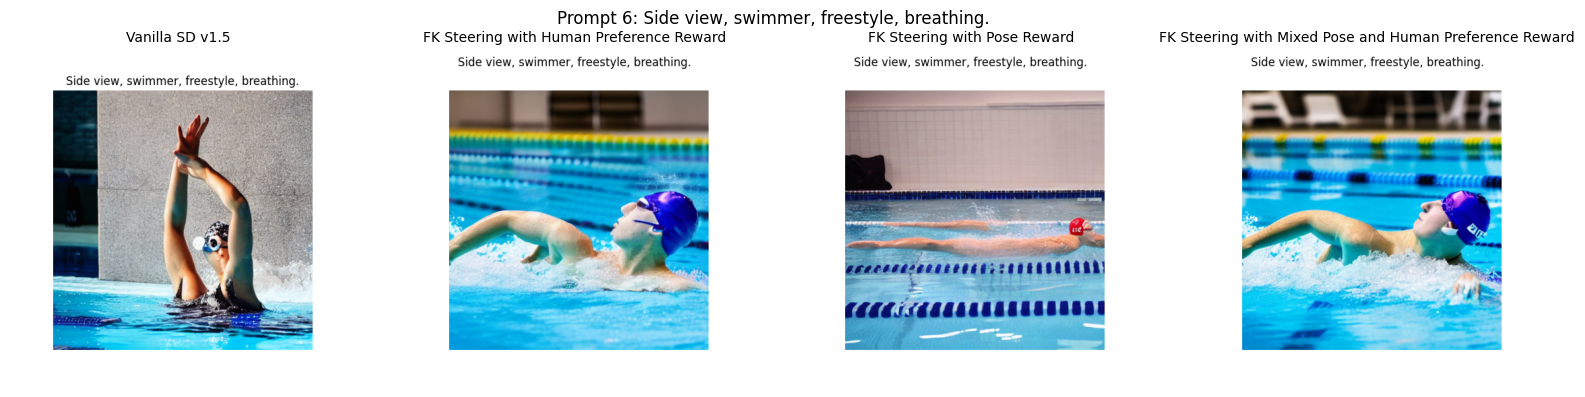

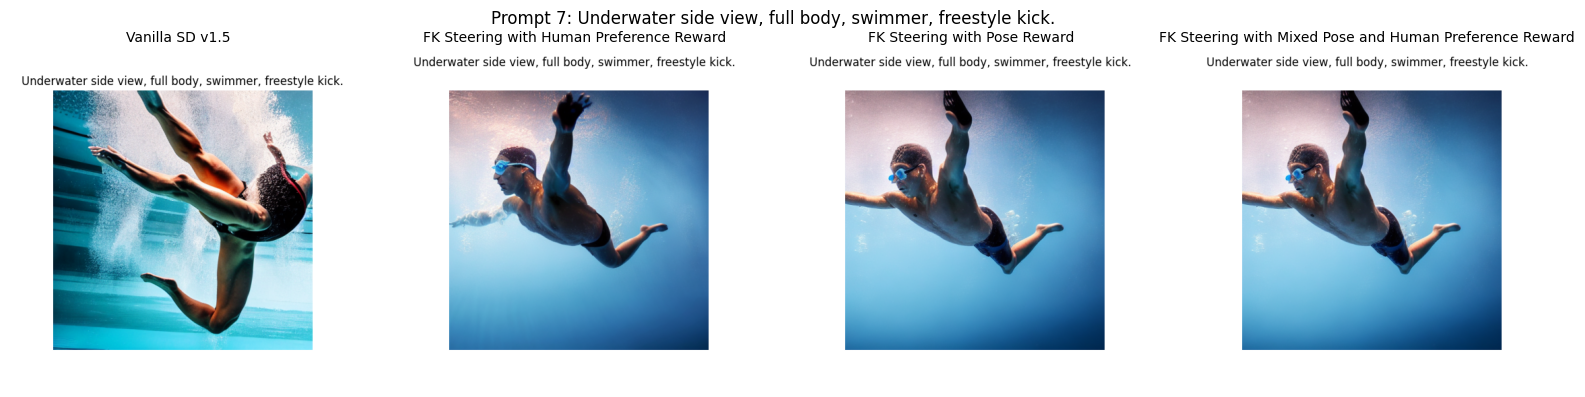

In [12]:
# Visual comparison grid across experiments
import os
from PIL import Image
import matplotlib.pyplot as plt

root_out = "output"  # base outputs directory
exp_ids = experiment_output_ids  # dict: run_id -> title

# Collect image file count from first experiment
first_run = next(iter(exp_ids.keys()))
images_dir = os.path.join(root_out, first_run, "images")
if not os.path.isdir(images_dir):
    raise FileNotFoundError(f"Images directory missing: {images_dir}")

# Assume files named 0.png, 1.png, ...
indices = sorted(
    int(f.split(".")[0]) for f in os.listdir(images_dir) if f.endswith(".png")
)
print("Found indices:", indices)

# Build mapping of run_id -> images directory
run_image_dirs = {
    run_id: os.path.join(root_out, run_id, "images") for run_id in exp_ids
}

# Sanity check same count
for run_id, d in run_image_dirs.items():
    missing = [i for i in indices if not os.path.isfile(os.path.join(d, f"{i}.png"))]
    if missing:
        raise RuntimeError(f"Run {run_id} missing indices: {missing}")

# Use prompt_data for row titles (prompt text)
prompt_texts = [item["prompt"] for item in prompt_data]
if len(prompt_texts) < len(indices):
    print("Warning: fewer prompts than images; titles may be truncated.")

for i in indices:
    fig, axes = plt.subplots(1, len(exp_ids), figsize=(4 * len(exp_ids), 4))
    if len(exp_ids) == 1:
        axes = [axes]
    for ax, (run_id, title) in zip(axes, exp_ids.items()):
        img_path = os.path.join(run_image_dirs[run_id], f"{i}.png")
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    row_title = prompt_texts[i] if i < len(prompt_texts) else f"Prompt {i}"
    fig.suptitle(f"Prompt {i}: {row_title}", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()